#  What happens to the climate if we perturb greenhouse gases?
## GEOL 202 - Lab 5 - Atmospheric radiation in climlab

Based on chapters 11-13 of [The Climate Laboratory](https://brian-rose.github.io/ClimateLaboratoryBook) by [Brian E. J. Rose](http://www.atmos.albany.edu/facstaff/brose/index.html), University at Albany.

What would happen to the climate if we removed CO$_2$?  What about doubling it?  How do we compare effects of different greenhouse gases?  In this lab, we will develop some tools that help us address that question quantitatively.

We will introduce a few new concepts to build on our experience with the theoretical N-layer atmosphere from previous weeks.  We will plot and interpret **skew-T diagrams** for the atmosphere's vertical structure, use a **radiative transfer model**, and compute **instantaneous radiative forcing**.


The goals of this lab are to practice
1. interpreting figures, and
2. thinking like a climate modeller.

## 1. Describing the true thermal structure of the atmosphere

Last lab, we found that the greenhouse effect strongly depends on the atmosphere having different temperatures in each layer.  An isothermal atmosphere (same temperature from bottom to top) would produce no additional warming with added absorbers.

In atmospheric science, we use **Skew-T** diagrams to analyse the thermal profile of the atmosphere.  Let's look at an example skew-T and practice reading it.  

Below is a skew-T diagram of the observed, annual global mean temperature profile.  This [National Weather Service interactive](https://www.weather.gov/jetstream/skewt) will help orient you to the lines included on the diagram.  Focus on the temperature and pressure lines.  In the atmosphere, pressure is a proxy for elevation.

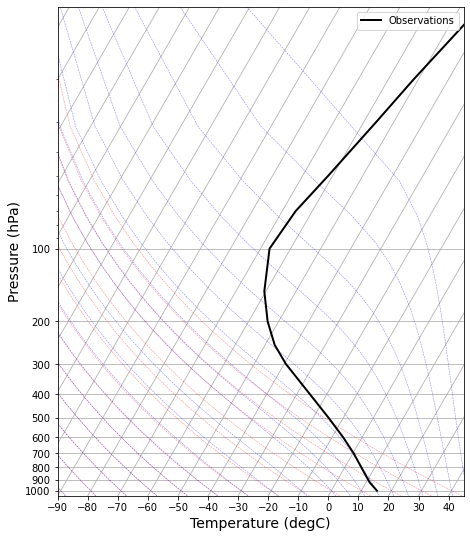

### Questions: skew-T orientation
1. Where is the Earth surface on the diagram?  Where is the top of the atmosphere?

*your response*

2. Describe how an isothermal atmosphere would appear on this diagram.

*your response*

3. Now looking at the observed annual global mean line above: describe how the temperature changes as you go up through the atmosphere.

*your response*

4. At what pressure level does the temperature trend switch from cooling to warming with increasing elevation?

*your response*

**In the sections below, we are going to look at what factors make that observed thermal profile look the way it does.**

### For fun: how to plot a skew-T

Want to see how we made the plot above?  Here's the Python code.

In [1]:
#  This code is used just to create the skew-T plot of global, annual mean air temperature
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
from metpy.plots import SkewT  ## using a package called MetPy for skew-T functionality

ncep_url = "http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/ncep.reanalysis.derived/"
ncep_air = xr.open_dataset( ncep_url + "pressure/air.mon.1981-2010.ltm.nc", use_cftime=True)
#  Take global, annual average 
coslat = np.cos(np.deg2rad(ncep_air.lat))
weight = coslat / coslat.mean(dim='lat')
Tglobal = (ncep_air.air * weight).mean(dim=('lat','lon','time'))

In [2]:
def make_skewT():
    fig = plt.figure(figsize=(9, 9))
    skew = SkewT(fig, rotation=30)
    skew.plot(Tglobal.level, Tglobal, color='black', linestyle='-', linewidth=2, label='Observations')
    skew.ax.set_ylim(1050, 10)
    skew.ax.set_xlim(-90, 45)
    # Add the relevant special lines
    skew.plot_dry_adiabats(linewidth=0.5)
    skew.plot_moist_adiabats(linewidth=0.5)
    #skew.plot_mixing_lines()
    skew.ax.legend()
    skew.ax.set_xlabel('Temperature (degC)', fontsize=14)
    skew.ax.set_ylabel('Pressure (hPa)', fontsize=14)
    return skew

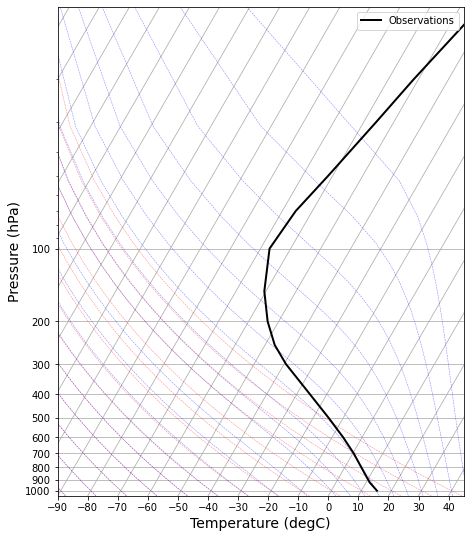

In [3]:
skew = make_skewT()

## 2. Radiative equilibrium

The concept of **radiative equilibrium** means that we **ignore all methods of heat exchange except for radiation**, and ask what temperature profile would exist under that assumption?

Last week we approached that question in simplified form, using only two layers.  Basically, we reach radiative equilibrium when **energy is received and lost through radiation at the same rate in every layer**.


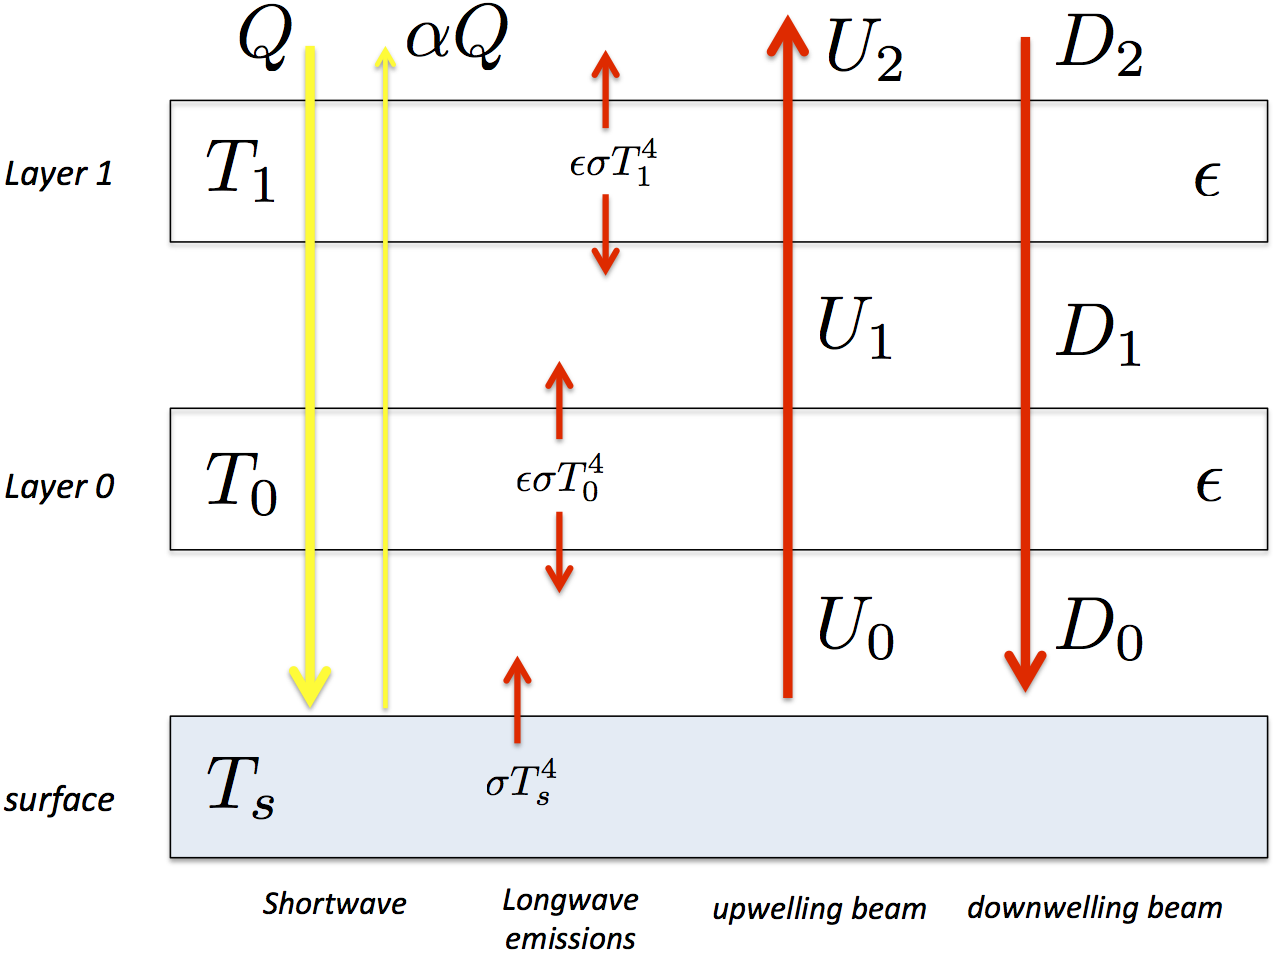


Clearly, our atmosphere has more structure than two block layers.  In analysing absorption spectra, we also found that different greenhouse gases absorb different wavelengths, so we will now account for that.


We are going to use a **radiative transfer model** to explicitly compute the shortwave and longwave beams, and the warming/cooling of each layer associated with the radiative sources and sinks of energy.

Our model will slice up the atmospheric air column into a series of layers, and calculate the *emission* and *absorption* of radiation within each layer.  Because of the complicated dependence of emission/absorption features on the wavelength of radiation and the different gases, the beam is divided up into many different pieces representing different parts of the electromagnetic spectrum.

We will not look explicitly at this complexity here, but we will *use a model* that represents these processes at the same level of detail we would in a global climate model (GCM).

## 3. Setting up a column radiation model

We're now going to use the package **climlab** to run a **complex radiation model**, one that accounts for the spectral absorption properties of different gases.

climlab actually provides two different "GCM-level" [radiation codes](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.Radiation.html):

- The [CAM3 radiation module](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.CAM3.html) from NCAR (essentially the same radiation code used in our CESM simulations)
- The [RRTMG (Rapid Radiative Transfer Model)](https://climlab.readthedocs.io/en/latest/api/climlab.radiation.RRTMG.html) which is used in many current GCMs.

The links above take you to the online [climlab documentation](http://climlab.readthedocs.io/en/latest/intro.html).

We're going to use a model called the [Rapid Radiative Transfer Model](http://rtweb.aer.com/rrtm_frame.html) or RRTMG. This is a "serious" and widely-used radiation model, used in many comprehensive GCMs and Numerical Weather Prediction models.

climlab provides an easy-to-use Python wrapper for the RRTMG code.

### Creating the model instance

In [ ]:
import climlab

## Do a hacky import of vertical levels and water vapor from CESM simulations
## See https://brian-rose.github.io/ClimateLaboratoryBook/courseware/radeq.html#water-vapor-data
lev_cesm = np.array([  3.544638,   7.388814,  13.967214,  23.944625,  37.23029 ,  53.114605,
        70.05915 ,  85.439115, 100.514695, 118.250335, 139.115395, 163.66207 ,
       192.539935, 226.513265, 266.481155, 313.501265, 368.81798 , 433.895225,
       510.455255, 600.5242  , 696.79629 , 787.70206 , 867.16076 , 929.648875,
       970.55483 , 992.5561  ])

qglobal_spec_humid = np.array([2.16104904e-06, 2.15879387e-06, 2.15121262e-06, 2.13630949e-06,
       2.12163684e-06, 2.11168002e-06, 2.09396914e-06, 2.10589390e-06,
       2.42166155e-06, 3.12595653e-06, 5.01369691e-06, 9.60746488e-06,
       2.08907654e-05, 4.78823747e-05, 1.05492451e-04, 2.11889055e-04,
       3.94176751e-04, 7.10734458e-04, 1.34192099e-03, 2.05153261e-03,
       3.16844784e-03, 4.96883408e-03, 6.62218037e-03, 8.38350326e-03,
       9.38620899e-03, 9.65030544e-03])

In [ ]:
#  Make a model on same vertical domain as CESM
mystate = climlab.column_state(lev=lev_cesm, water_depth=2.5)
mystate

In [ ]:
## Give it a radiation model
radmodel = climlab.radiation.RRTMG(name='Radiation (all gases)',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=qglobal_spec_humid,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
radmodel

Let's look at what we've put together.  We have an object called `radmodel` that has a vertical structure with temperature profile, water vapor, an albedo, and radiatively active gases.  You can inspect the initial state: $T_s$ for the surface temperature and $T_{atm}$ for atmospheric temperatures varying with height. 

In [ ]:
#  Here's the state dictionary we already created:
radmodel.state

In [ ]:
#  Here are the pressure levels in hPa
radmodel.lev

And, very importantly: **`radmodel` has specified concentrations of greenhouse gases**, stored in the attribute `absorber_vmr`

In [ ]:
radmodel.absorber_vmr

Most are just a single number because they are assumed to be well mixed in the atmosphere.  For example, let's look at CO2 concentration in ppm.

In [ ]:
#  E.g. the CO2 content (a well-mixed gas) in parts per million
radmodel.absorber_vmr['CO2'] * 1E6

### Exercise: inspect the absorbers in our model.

What greenhouse gases are present?  What is their concentration?

*your answer here*

What gases that we've talked about are not included?

*your answer here*

### Exercise: plot the ozone profile
Recall that we talked about the important vertical structure of ozone: O$_3$ hangs out in the upper atmosphere and shields us from UV up there, but has changing concentrations (and effects) in the lower atmosphere due to pollution.  For this reason, we set up our model with a specific vertical profile of ozone, unlike the greenhouse gases that we assume are well-mixed to a uniform concentration.

Let's make a plot to look at the vertical profile of O$_3$.

First, **confirm that we have some data available to plot**.  We should see two arrays of the same shape; if not, there is a problem.

In [ ]:
# here is the data we need for the plot, as a plain numpy arrays:
print(radmodel.lev)
print(radmodel.absorber_vmr['O3'])

In [ ]:
## make a simple plot - edit the code below to plot the data and add axes labels
fig, ax = plt.subplots()
ax.plot(...)

### Water vapor

The other gas that gets special treatment is water vapor.  You may have noticed it is not included in the `radmodel.absorber_vmr` list.  That's because we need water vapor for other climate processes, like precipitation, that are handled separately in the model.  The radiative transfer model still knows there is water vapor, stored in the form of specific humidity at each pressure level:

In [ ]:
#  specific humidity in kg/kg, on the same pressure axis
radmodel.specific_humidity

## 4. Radiative equilibrium in our column model

Now we are going to let the model run forward in time with these initial greenhouse gas concentrations.

Here are the initial conditions for temperature at the surface and in the atmosphere:

In [ ]:
radmodel.Ts

In [ ]:
radmodel.Tatm

Now let's take a single time step forward and see what happens.

In [ ]:
radmodel.step_forward()

In [ ]:
radmodel.Ts

**What happened to the surface temperature?  How could you examine the atmospheric temperature?**

*your notes here*

**Do you suppose this system is in radiative equilibrium?**

The main job of the radiative transfer model, which we will not get into in detail here, is to track the shortwave and longwave fluxes up and down between each model layer, accounting for differences across wavelength.  Think of it like a more sophisticated and automated version of our N-layer model, tracking the beams of radiation from surface to top of atmosphere.

We can use `radmodel` to tell us about the radiative balance at the top of the atmosphere, like so:

In [ ]:
radmodel.ASR - radmodel.OLR

**Is the modelled climate gaining or losing energy?**

### Now, run the model until it reaches equilibrium

Here we want to step forward in time until the model is very close to energy balance.

We can use a `while` loop, which will run until the top-of-atmosphere imbalance is less than or equal to 0.01:

In [ ]:
while np.abs(radmodel.ASR - radmodel.OLR) > 0.01:
    radmodel.step_forward()

Check the energy budget again:

In [ ]:
#  Check the energy budget again
radmodel.ASR - radmodel.OLR

Once the system is in radiative equilibrium, the imbalance should be small.

### And compare it to observations

In [ ]:
def add_profile(skew, model, linestyle='-', color=None):
    line = skew.plot(model.lev, model.Tatm - climlab.constants.tempCtoK,
             label=model.name, linewidth=2)[0]
    skew.plot(1000, model.Ts - climlab.constants.tempCtoK, 'o', 
              markersize=8, color=line.get_color())
    skew.ax.legend()

In [ ]:
skew = make_skewT()
add_profile(skew, radmodel)
skew.ax.set_title('Pure radiative equilibrium', fontsize=18);

### Exercise: analyse the model vs. data comparison

What do you see in the plot above?  Does the radiative equilibrium look like the observed vertical temperature profile in the atmosphere?  How are the curves similar or different?

*your response here*

## 5. Analysing the effects of different gases on the equilibrium profile

**Models are for experimenting and playing with!**

We have just built a single-column radiation model with several different absorbing gases. *We can learn about their effects by taking them away.*

First, let's see how the profile would be different with no water vapor.

### Radiative equilibrium with no water vapor

We will set up a clone of our existing model, then remove the water vapor.  We will run the new no-H2O model forward to equilibrium and look at its profile.

In [ ]:
# Make an exact clone of our existing model
radmodel_noH2O = climlab.process_like(radmodel)
radmodel_noH2O.name = 'Radiation (no H2O)'
radmodel_noH2O

In [ ]:
#  Here is the water vapor profile we started with
radmodel_noH2O.specific_humidity

In [ ]:
radmodel_noH2O.specific_humidity *= 0.

In [ ]:
# Here's the new one
radmodel_noH2O.specific_humidity

In [ ]:
#  it's useful to take a single step first before starting the while loop
#   because the model fields won't get updated 
#  (and thus show the effects of removing water vapor)
#  until we take a step forward
radmodel_noH2O.step_forward()

## now run to equilibrium as before
while np.abs(radmodel_noH2O.ASR - radmodel_noH2O.OLR) > 0.01:
    radmodel_noH2O.step_forward()

In [ ]:
## confirm it's reached equilibrium
radmodel_noH2O.ASR - radmodel_noH2O.OLR

### Exercise: interpret the radiative role of water vapor

In [ ]:
skew = make_skewT()
for model in [radmodel, radmodel_noH2O]:
    add_profile(skew, model)

What does this tell us about the radiative role of water vapor?  Where and how is the profile with no H2O different from the previous model?

### Exercise: radiative equilibrium without CO2

Following the steps above, make another model, but this time instead of removing the water vapor, remove the CO$_2$!

Make another skew-T plot comparing all three model results.

In [ ]:
## your code here

## 6. Radiative forcing from a doubling in CO2

Finally, a sneak peek at some of the concepts we'll develop after break.

Let’s say we instantaneously double atmospheric CO$_2$. What happens?

- The atmosphere is less efficient at radiating energy away to space.
- OLR will decrease
- The climate system will begin gaining energy.

When we increased absorptivity in our two-layer atmosphere last week, we computed the **radiative forcing**, a positive number in W m$^{-2}$

$$ \Delta R = -\Delta OLR$$

$\Delta R$ is a measure of the rate at which energy begins to accumulate in the climate system after an abrupt increase in greenhouse gases, but *before any change in climate* (i.e. temperature).

We can use our radiative model as a tool to compute the radiative forcing associated with such changes to specific greenhouse gases.

### A little cheat: adding atmospheric dynamics

You saw in the radiative equilibrium profiles above that purely radiative balance did not reproduce the observed temperature profile in Earth's atmosphere.  

*Vertical motion (convection)* is another way heat is redistributed in the atmosphere.  We have not yet talked in detail about how convection works -- stay tuned after break! -- but we can use climlab to build a model that accounts for convection too.

In [ ]:
#  Build the radiation model -- just like we already did
rad = climlab.radiation.RRTMG(name='Radiation',  # give our model a name!
                              state=mystate,   # give our model an initial condition!
                              specific_humidity=qglobal_spec_humid,  # tell the model how much water vapor there is
                              albedo = 0.25,  # this the SURFACE shortwave albedo
                              timestep = climlab.constants.seconds_per_day,  # set the timestep to one day (measured in seconds)
                             )
#  Now create the convection model
conv = climlab.convection.ConvectiveAdjustment(name='Convection',
                                               state=mystate,
                                               adj_lapse_rate=6.5,
                                               timestep=rad.timestep,
                                              )
#  Here is where we build the model by coupling together the two components - letting them interact
rcm = climlab.couple([rad, conv], name='Radiative-Convective Model')

Check the default CO2 concentration:

In [ ]:
rcm.subprocess['Radiation'].absorber_vmr['CO2']

Integrate for a few years to approach equilibrium, before we mess with the CO2.

In [ ]:
rcm.integrate_years(5)

In [ ]:
## Check it
rcm.ASR - rcm.OLR

### Make a clone

Exactly as we did above, make a copy of the model that we will then edit.

In [ ]:
# Make an exact clone with same temperatures
rcm_2xCO2 = climlab.process_like(rcm)
rcm_2xCO2.name = 'Radiative-Convective Model (2xCO2 initial)'

Check the CO2 concentration:

In [ ]:
#  Check to see that we indeed have the same CO2 amount
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2']

Now double it!

In [ ]:
rcm_2xCO2.subprocess['Radiation'].absorber_vmr['CO2'] *= 2

### Find the radiative forcing from the model diagnostics

The simplest measure of radiative forcing is the instantaneous change in the energy budget before the temperatures have a chance to adjust.  

The model is keeping track of the energy budget for us. To get this we need to call the compute_diagnostics method, (but not any forward timestep).

In [ ]:
rcm_2xCO2.compute_diagnostics()

Now take a look at the changes in the SW and LW budgets between the original and the 2xCO2 case:

In [ ]:
rcm_2xCO2.ASR - rcm.ASR

In [ ]:
rcm_2xCO2.OLR - rcm.OLR

And we can find the **instantaneous radiative forcing** of a doubling in CO2:

In [ ]:
DeltaR_instant = (rcm_2xCO2.ASR - rcm_2xCO2.OLR) - (rcm.ASR - rcm.OLR)
DeltaR_instant

You should see the radiative forcing for a doubling of CO2 in this model is 2.18 W m$^{-2}$.

As we can see above, almost all of the radiative forcing appears in the longwave. We have made the atmosphere **more optically thick** by adding CO$_2$.

Think about this the same way we increased the absorptivity / emissivity parameter $\epsilon$ in the simple grey-gas model.

#### Food for thought: how can we use instantaneous radiative forcing to compare the effects of various greenhouse gases?

Have a great Spring Break!